In [1]:
import pickle
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from math import sqrt
from collections import OrderedDict
from itertools import product
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
playlists_df_full = pd.read_csv('D:\\Università\\SL\\playlists.csv')
playlists_df_full.head()

,id,num_followers,collaborative,num_tracks,track_acousticness_avg,track_acousticness_std,track_album_popularity_avg,track_album_popularity_std,track_album_popularity_max,track_artists_genres_unique,...,track_std_artist_num_followers_std,track_std_artist_popularity_avg,track_std_artist_popularity_std,track_tempo_avg,track_tempo_std,track_time_signature_mode,track_time_signature_unique,track_valence_avg,track_valence_std,genre
0,37i9dQZF1DX9sIqqvKsjG8,1359200,False,304,0.991040,0.007050,50.620000,12.132419,69,6,...,0.049749,0.000000,0.000000,116.403260,33.636115,4,4,0.244111,0.137205,other
1,5oxZIYU1L9N1CczN0C4JkM,372240,False,519,0.781945,0.276167,42.810000,5.611943,53,10,...,1050.024652,0.309889,1.507600,116.959680,34.743877,4,4,0.318979,0.202490,other
2,37i9dQZF1DWYmSg58uBxin,50518,False,125,0.952290,0.099856,44.450000,8.858188,64,21,...,15705.509150,0.485000,2.165012,109.472630,36.706674,4,4,0.157351,0.103388,other
3,4rmUneFYK2N9lxkaxJ3Qko,16862,False,55,0.518699,0.381347,42.345455,17.886733,65,28,...,151867.916528,1.154545,3.465247,119.323091,24.111534,4,3,0.092696,0.075302,other
4,37i9dQZF1DX8f5qTGj8FYl,204994,False,80,0.114581,0.135392,26.700000,13.990533,54,64,...,29321.146316,0.692723,2.162816,113.944575,21.818617,4,3,0.759212,0.163188,funk


### Preprocessing the Data

In [3]:
#Transforming the num of followers
playlists_df_full['log_num_followers'] = np.log(list(playlists_df_full['num_followers']+1))
playlists_df_full.drop(['num_followers'], axis=1, inplace=True)
target = playlists_df_full['log_num_followers']
playlists_df_full.drop(['log_num_followers'], axis=1, inplace=True)

In [4]:
#Preprocessing categorical variables
playlists_df_full.drop(['collaborative'], axis=1, inplace=True)
categorical_predictors = ['genre', 'track_time_signature_mode', 'track_key_mode']
numerical_predictors = list(set(playlists_df_full.columns.values) - set(categorical_predictors))

playlists_df_full = pd.get_dummies(playlists_df_full, prefix = categorical_predictors, 
                                         columns = categorical_predictors, drop_first = True)

In [6]:
#Splitting the data into Train, Test and Validation
X_train, X_test_val, y_train, y_test_val = train_test_split(playlists_df_full, target, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=123)

In [8]:
#Sotring the id
id_train = X_train['id']
id_val = X_val['id']
id_test = X_test['id']
id_test_val = X_test_val['id']
X_train.drop(['id'], axis = 1, inplace = True)
X_val.drop(['id'], axis = 1, inplace = True)
X_test.drop(['id'], axis = 1, inplace = True)
X_test_val.drop(['id'], axis = 1, inplace = True)

In [9]:
#Scaling the numerical variables
for col in X_train.columns:
    if (X_train[col] == 0).all():
        X_train.drop(col, axis=1, inplace=True)
        X_test.drop(col, axis=1, inplace=True)
        X_val.drop(col, axis=1, inplace=True)
        X_test_val.drop(col, axis=1, inplace=True)
    else:
        if not np.logical_or((X_train[col]==0), ((X_train[col]==1))).all():
            mean_train = X_train[col].mean()
            std_train = X_train[col].std()
            X_train[col] = (X_train[col] - mean_train) / std_train
            X_val[col] = (X_val[col] - mean_train) / std_train
            X_test[col] = (X_test[col] - mean_train) / std_train
            X_test_val[col] = (X_test_val[col] - mean_train) / std_train

### Linear Regression

In [10]:
r2_test_simple = []
RMSE_test_simple = []

In [11]:
simple_linear = LinearRegression().fit(X_train, y_train) 
pred_linear = simple_linear.predict(X_test_val)

In [105]:
print('-- Linear Regression with all predictors  --')
print('Training R^2: {}'.format(simple_linear.score(X_train, y_train)))
print('Test R^2: {}'.format(simple_linear.score(X_test_val, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_linear))))

-- Linear Regression with all predictors  --
Training R^2: 0.22483279754756136
Test R^2: 0.20218152679274337
Test RMSE: 3.58186261697588


In [13]:
r2_test_simple.append(simple_linear.score(X_test_val, y_test_val))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_linear)))

In [114]:
joblib.dump(simple_linear, 'D:\\Università\\SL\\Pickle_models\\simple_linear.pkl')

['D:\\Università\\SL\\Pickle_models\\simple_linear.pkl']

### Ridge Regression

In [14]:
#Training the model
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
ridge_linear = RidgeCV(alphas=alphas, fit_intercept=True).fit(X_train, y_train)
pred_ridge = ridge_linear.predict(X_test_val)

In [104]:
print('-- Ridge Regression with all predictors --')
print('Training R^2: {}'.format(ridge_linear.score(X_train, y_train)))
print('Test R^2: {}'.format(ridge_linear.score(X_test_val, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_ridge))))

-- Ridge Regression with all predictors --
Training R^2: 0.22438893398122872
Test R^2: 0.20417025701507696
Test RMSE: 3.5773955587813444


In [16]:
r2_test_simple.append(ridge_linear.score(X_test_val, y_test_val))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_ridge)))

In [115]:
joblib.dump(ridge_linear, 'D:\\Università\\SL\\Pickle_models\\ridge_linear.pkl') 

['D:\\Università\\SL\\Pickle_models\\ridge_linear.pkl']

### Lasso Regression

In [17]:
#Training the model
lasso_linear = LassoCV(alphas=alphas, fit_intercept=True).fit(X_train, y_train)
pred_lasso = lasso_linear.predict(X_test_val)

In [102]:
print('-- Lasso Regression with all predictors --')
print('Training R^2: {}'.format(lasso_linear.score(X_train, y_train)))
print('Test R^2: {}'.format(lasso_linear.score(X_test_val, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_lasso))))

-- Lasso Regression with all predictors --
Training R^2: 0.22454578265509295
Test R^2: 0.20345714168337958
Test RMSE: 3.578997989710761


In [19]:
r2_test_simple.append(lasso_linear.score(X_test_val, y_test_val))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_lasso)))

In [116]:
joblib.dump(lasso_linear, 'D:\\Università\\SL\\Pickle_models\\lasso_linear.pkl')

['D:\\Università\\SL\\Pickle_models\\lasso_linear.pkl']

### Random Forest

In [126]:
RF_params = OrderedDict(
    n_estimators = [2**(i+2) for i in np.arange(7)],
    max_features = [0.1, 0.3, 0.5, 0.7, 0.9]
)

In [130]:
for i, (n, f) in enumerate(product(*RF_params.values())):
    
    # Taking the best hyperparameters Random Forest Regressor
    RF = RandomForestRegressor(oob_score=False, n_estimators=n, max_features=f, n_jobs=-1, 
                                    random_state=22).fit(X_train, y_train)
    
    actual_score = RF.score(X_test_val, y_test_val)
    if i == 0:
        best_score_RF = actual_score
        best_params_RF = (n, f)
        
    elif actual_score > best_score_RF:
            best_score_RF = actual_score
            best_params_RF = (n, f)

print('-- Random Forest Regression --')
print('Maximum R^2 test score = {}'.format(best_score_RF))
print('Optimal n_estimators = {}'.format(best_params_RF[0]))
print('Optimal max_features = {}'.format(best_params_RF[1]))

-- Random Forest Regression --
Maximum R^2 test score = 0.45146030200378284
Optimal n_estimators = 256
Optimal max_features = 0.9


In [20]:
#Training the model
RF_simple = RandomForestRegressor(oob_score=False, n_estimators=256, max_features=0.5, n_jobs=-1, 
                                     random_state=22).fit(X_train, y_train)

pred_RF = RF_simple.predict(X_test_val)
print('-- Best Random Forest Regression --')
print("Training R^2: {}".format(RF_simple.score(X_train, y_train)))
print("Test R^2: {}".format(RF_simple.score(X_test_val, y_test_val)))
print('Test RMSE: ', sqrt(mean_squared_error(y_test_val, pred_RF)))

-- Best Random Forest Regression --
Training R^2: 0.9260064305231231
Test R^2: 0.45126175258055223
Test RMSE:  2.9705679858790766


In [21]:
r2_test_simple.append(RF_simple.score(X_test_val, y_test_val))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_RF)))

In [22]:
joblib.dump(RF_simple, 'D:\\Università\\SL\\Pickle_models\\RF_regression.pkl')

['D:\\Università\\SL\\Pickle_models\\RF_regression.pkl']

### Support Vector Machine

In [125]:
SVM_params = OrderedDict(
    gamma = ['scale', 'auto'],
    C = [0.001, 0.01, 0.1, 1, 10, 25, 50, 100, 1000]
)

In [129]:
k = 'rbf'
for i, (gamma, C) in enumerate(product(*SVM_params.values())):
    
    # Best Hyperparameters for SVM
    SVM = svm.SVR(gamma=gamma, C=C, kernel=k).fit(X_train, y_train)

    actual_score = SVM.score(X_test_val, y_test_val)
    if i == 0:
        best_score_SVM = actual_score
        best_params_SVM = (gamma, C)
        
    elif actual_score > best_score_SVM:
            best_score_SVM = actual_score
            best_params_SVM = (gamma, C)

print('-- Support Vector Machine --')
print('Maximum R^2 test score = {}'.format(best_score_SVM))
print('Optimal gamma = {}'.format(best_params_SVM[0]))
print('Optimal C = {}'.format(best_params_SVM[1]))

-- Support Vector Machine --
Maximum R^2 test score = 0.3891002228049627
Optimal gamma = scale
Optimal C = 25


In [23]:
#Training the model
SVM_model = svm.SVR(gamma='scale', C=25, kernel='rbf').fit(X_train, y_train)
pred_SVM = SVM_model.predict(X_test_val)
print('-- Best Support Vector Machine Regression --')
print("Training R^2: {}".format(SVM_model.score(X_train, y_train)))
print("Test R^2: {}".format(SVM_model.score(X_test_val, y_test_val)))
print('Test RMSE: ', sqrt(mean_squared_error(y_test_val, pred_SVM)))

-- Best Support Vector Machine Regression --
Training R^2: 0.7321200618953074
Test R^2: 0.3891002228049627
Test RMSE:  3.134309389725119


In [24]:
r2_test_simple.append(SVM_model.score(X_test_val, y_test_val))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_SVM)))

In [25]:
joblib.dump(SVM_model, 'D:\\Università\\SL\\Pickle_models\\SVM_regression.pkl')

['D:\\Università\\SL\\Pickle_models\\SVM_regression.pkl']

### AdaBoost Regressor

In [124]:
AB_params = OrderedDict(
    base_depths = [2, 4, 6, 8],
    n_estimators = [2**(i+2) for i in np.arange(7)]
)

In [128]:
l_rate = 0.05

for i, (d, n) in enumerate(product(*AB_params.values())):
    
    #Best Hyperparameters for AB
    AB = AdaBoostRegressor(DecisionTreeRegressor(max_depth=d, random_state=123), n_estimators=n, 
                                learning_rate=l_rate, random_state=123).fit(X_train, y_train)
    
    actual_score = AB.score(X_test_val, y_test_val)
    if i == 0:
        best_score_AB = actual_score
        best_params_AB = (d, n)
        
    elif actual_score > best_score_AB:
            best_score_AB = actual_score
            best_params_AB = (d, n)

print('-- AdaBoost Regression --')
print('Maximum R^2 test score = {}'.format(best_score_AB))
print('Optimal base tree max_depth = {}'.format(best_params_AB[0]))
print('Optimal n_estimators = {}'.format(best_params_AB[1]))

-- AdaBoost Regression --
Maximum R^2 test score = 0.39368499973698334
Optimal base tree max_depth = 8
Optimal n_estimators = 256


In [26]:
#Training the model
AB_model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8, random_state=123), 
                                 n_estimators=256, learning_rate=0.05, 
                                 random_state=22).fit(X_train, y_train)
pred_ab = AB_model.predict(X_test_val)
print('-- Best AdaBoost Regression --')
print("Training R^2: {}".format(AB_model.score(X_train, y_train)))
print("Test R^2: {}".format(AB_model.score(X_test_val, y_test_val)))
print('Test RMSE: ', sqrt(mean_squared_error(y_test_val, pred_ab)))

-- Best AdaBoost Regression --
Training R^2: 0.6102412616154472
Test R^2: 0.3928549392400644
Test RMSE:  3.1246624868905926


In [27]:
r2_test_simple.append(AB_model.score(X_test_val, y_test_val))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_ab)))

In [28]:
joblib.dump(AB_model, 'D:\\Università\\SL\\Pickle_models\\AdaBoost_regression.pkl')

['D:\\Università\\SL\\Pickle_models\\AdaBoost_regression.pkl']

### ENSEMBLE : Random Forest + Support Vector Machine + AdaBoost + Ridge + Lasso + Linear Regression

In [29]:
#Computing the average predictions of all the models
pred_all = np.zeros(len(X_test_val))
models = [ridge_linear, simple_linear, lasso_linear, RF_simple, AB_model, SVM_model]
for model in models:
    predict = model.predict(X_test_val)
    pred_all += predict

pred_all = pred_all / len(models)
print('--First Ensemble Method--')
print('Test R^2: {}'.format(r2_score(y_test_val, pred_all)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_all))))

--First Ensemble Method--
Test R^2:  0.3866791933901552
Test RMSE:  3.1405139687764474


In [30]:
r2_test_simple.append(r2_score(y_test_val, pred_all))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_all)))

### ENSEMBLE : Random Forest + Support Vector Machine + AdaBoost

In [101]:
#Computing the average predictions of the best three models
pred_RF_SVM_AB = np.zeros(len(X_test_val))
models_chosen = [RF_simple, SVM_model, AB_model]
for model in models_chosen:
    predict = model.predict(X_test_val)
    pred_RF_SVM_AB += predict
    
pred_RF_SVM_AB= pred_RF_SVM_AB / len(models_chosen)
print('--Second Ensemble Method--')
print('Test R^2: {}'.format(r2_score(y_test_val, pred_RF_SVM_AB)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_RF_SVM_AB))))

--Second Ensemble Method--
Test R^2: 0.4719743871310579
Test RMSE: 2.91396529473276


In [32]:
r2_test_simple.append(r2_score(y_test_val, pred_RF_SVM_AB))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test_val, pred_RF_SVM_AB)))

### META MODEL - Linear Regression with Random Forest + Support Vector Machine + AdaBoost Ridge + Lasso + Linear Regression

In [33]:
#Taking the predictions of all the models
meta_X_train = pd.DataFrame(columns = models)
meta_X_test = pd.DataFrame(columns = models)
for model in models:
    meta_X_train[model] = model.predict(X_val)
    meta_X_test[model] = model.predict(X_test)

In [34]:
#and then using the predictions as train dataset
meta_mod = LinearRegression().fit(meta_X_train, y_val)

pred_meta = meta_mod.predict(meta_X_test)
print('-- Meta model 1: Linear Regression with all models --')
print("Train R^2: {}".format(meta_mod.score(meta_X_train, y_val)))
print("Test R^2: {}".format(meta_mod.score(meta_X_test, y_test)))
print("Test RMSE: {}".format(sqrt(mean_squared_error(y_test, pred_meta))))

-- Meta model 1: Linear Regression with all models --
Train R^2: 0.49514501029017954
Test R^2: 0.4938784113020669
Test RMSE: 2.795454965255899


In [35]:
r2_test_simple.append(meta_mod.score(meta_X_test, y_test))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test, pred_meta)))

In [138]:
joblib.dump(meta_mod, "D:\\Università\\SL\\Pickle_models\\meta_mod_new.pkl") 

['D:\\Università\\SL\\Pickle_models\\meta_mod_new.pkl']

### META MODEL - Linear Regression with Random Forest + Support Vector Machine + AdaBoost 

In [36]:
#Taking the predictions of the best three models
meta_X_train_3 = pd.DataFrame(columns = models_chosen)
meta_X_test_3 = pd.DataFrame(columns = models_chosen)
for model in models_chosen:
    meta_X_train_3[model] = model.predict(X_val)
    meta_X_test_3[model] = model.predict(X_test)

In [38]:
#and then using the predictions as train dataset
meta_mod_3 = LinearRegression().fit(meta_X_train_3, y_val)

pred_meta_3 = meta_mod_3.predict(meta_X_test_3)
print('-- Meta model 2: Linear Regression with the best three models --')
print("Train R^2: {}".format(meta_mod_3.score(meta_X_train_3, y_val)))
print("Test R^2: {}".format(meta_mod_3.score(meta_X_test_3, y_test)))
print("Test RMSE: {}".format(sqrt(mean_squared_error(y_test, pred_meta_3))))

-- Meta model 2: Linear Regression with the best three models --
Train R^2: 0.4946097419790957
Test R^2: 0.49434926255685263
Test RMSE: 2.794154339300183


In [39]:
r2_test_simple.append(meta_mod_3.score(meta_X_test_3, y_test))
RMSE_test_simple.append(sqrt(mean_squared_error(y_test, pred_meta_3)))

In [137]:
joblib.dump(meta_mod_3, "D:\\Università\\SL\\Pickle_models\\meta_mod_3.pkl") 

['D:\\Università\\SL\\Pickle_models\\meta_mod_3.pkl']

### INTERACTION TERMS

In [40]:
audio_features_avg = ['track_acousticness_avg', 'track_album_popularity_avg', 'track_danceability_avg',
                    'track_duration_ms_avg', 'track_energy_avg', 'track_explicit_avg', 
                    'track_instrumentalness_avg', 'track_liveness_avg', 'track_loudness_avg', 'track_mode_avg', 
                    'track_speechiness_avg', 'track_tempo_avg', 'track_valence_avg']
genres = ['genre_metal', 'genre_pop rap', 'genre_country', 'genre_dance', 'genre_edm', 'genre_jazz', 'genre_soul',
 'genre_reggae', 'genre_blues', 'genre_korean pop', 'genre_rap', 'genre_r&b', 'genre_mellow', 'genre_pop',
 'genre_indie', 'genre_elect', 'genre_funk', 'genre_indie pop', 'genre_punk', 'genre_other', 'genre_hip hop',
 'genre_folk', 'genre_rock', 'genre_house', 'genre_classical']

cross_terms = audio_features_avg + genres

In [41]:
playlists_df_interaction = deepcopy(playlists_df_full)

for feature in audio_features_avg:
    for genre in genres:
        playlists_df_interaction[feature+'_X_'+genre] = playlists_df_full[feature] * playlists_df_full[genre]

In [42]:
X_train_int, X_test_val_int, y_train_int, y_test_val_int = train_test_split(playlists_df_interaction, target, 
                                                                            test_size=0.2, random_state=123)

In [43]:
X_val_int, X_test_int, y_val_int, y_test_int = train_test_split(X_test_val_int, y_test_val_int, 
                                                                test_size=0.5, random_state=123)

In [44]:
id_train_int = X_train_int['id']
id_val_int = X_val_int['id']
id_test_int = X_test_int['id']
id_test_val_int = X_test_val_int['id']
X_train_int.drop(['id'], axis = 1, inplace = True)
X_val_int.drop(['id'], axis = 1, inplace = True)
X_test_int.drop(['id'], axis = 1, inplace = True)
X_test_val_int.drop(['id'], axis = 1, inplace = True)

In [45]:
for col in X_train_int.columns:
    if (X_train_int[col] == 0).all():
        X_train_int.drop(col, axis=1, inplace=True)
        X_test_int.drop(col, axis=1, inplace=True)
        X_val_int.drop(col, axis=1, inplace=True)
        X_test_val_int.drop(col, axis = 1, inplace = True)
    else:
        # Taking only numerical variables
        if not np.logical_or((X_train_int[col]==0), ((X_train_int[col]==1))).all():
            mean_train = X_train_int[col].mean()
            std_train = X_train_int[col].std()
            X_train_int[col] = (X_train_int[col] - mean_train) / std_train
            X_val_int[col] = (X_val_int[col] - mean_train) / std_train
            X_test_int[col] = (X_test_int[col] - mean_train) / std_train
            X_test_val_int[col] = (X_test_val_int[col] - mean_train) / std_train

### Linear Regression

In [46]:
r2_test_int = []
RMSE_test_int = []

In [47]:
#Training the model
int_linear = LinearRegression().fit(X_train_int, y_train) 
pred_linear_int = int_linear.predict(X_test_val_int)

In [106]:
print('-- Linear Regression with Interaction Terms --')
print('Training R^2: {}'.format(int_linear.score(X_train_int, y_train)))
print('Test R^2: {}'.format(int_linear.score(X_test_val_int, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_linear_int))))

-- Linear Regression with Interaction Terms --
Training R^2: 0.2889510453728311
Test R^2: -6.779977369016876e+20
Test RMSE: 104416949781.1035


In [49]:
r2_test_int.append(int_linear.score(X_test_val_int, y_test_val))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_linear_int)))

In [136]:
joblib.dump(int_linear, 'D:\\Università\\SL\\Pickle_models\\int_linear.pkl')

['D:\\Università\\SL\\Pickle_models\\int_linear.pkl']

### Ridge Regression

In [50]:
#Training the model
ridge_int = RidgeCV(alphas=alphas, fit_intercept=True).fit(X_train_int, y_train)
pred_ridge_int = ridge_int.predict(X_test_val_int)

In [107]:
print('-- Ridge Regression with Interaction Terms --')
print('Training R^2: {}'.format(ridge_int.score(X_train_int, y_train)))
print('Test R^2: {}'.format(ridge_int.score(X_test_val_int, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_ridge_int))))

-- Ridge Regression with Interaction Terms --
Training R^2: 0.2638163447695431
Test R^2: 0.2072719962656916
Test RMSE: 3.5704173192628716


In [52]:
r2_test_int.append(ridge_int.score(X_test_val_int, y_test_val))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_ridge_int)))

In [131]:
joblib.dump(ridge_int, 'D:\\Università\\SL\\Pickle_models\\ridge_int.pkl') 

['D:\\Università\\SL\\Pickle_models\\ridge_int.pkl']

### Lasso Regression

In [53]:
#Training the model
lasso_int = LassoCV(alphas=alphas, fit_intercept=True).fit(X_train_int, y_train)
pred_lasso_int = lasso_int.predict(X_test_val_int)

In [108]:
print('-- Lasso Regression with Interaction Terms --')
print('Training R^2: {}'.format(lasso_int.score(X_train_int, y_train)))
print('Test R^2: {}'.format(lasso_int.score(X_test_val_int, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_lasso_int))))

-- Lasso Regression with Interaction Terms --
Training R^2: 0.253127660618521
Test R^2: 0.21949630309340484
Test RMSE: 3.5427814545581637


In [55]:
r2_test_int.append(lasso_int.score(X_test_val_int, y_test_val))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_lasso_int)))

In [132]:
joblib.dump(lasso_int, 'D:\\Università\\SL\\Pickle_models\\lasso_int.pkl')

['D:\\Università\\SL\\Pickle_models\\lasso_int.pkl']

### Random Forest

In [134]:
# HyperParameters on Random Forest Regressor
for i, (n, f) in enumerate(product(*RF_params.values())):
    
    RF = RandomForestRegressor(oob_score=False, n_estimators=n, max_features=f, n_jobs=-1, 
                                    random_state=22).fit(X_train_int, y_train)

    actual_score = RF.score(X_test_val_int, y_test_val)
    if i == 0:
        best_score_RF_int = actual_score
        best_params_RF_int = (n, f)
        
    elif actual_score > best_score_RF_int:
            best_score_RF_int = actual_score
            best_params_RF_int = (n, f)

print('-- Random Forest Regression with Interaction Terms--')
print('Maximum R^2 test score = {}'.format(best_score_RF_int))
print('Optimal n_estimators = {}'.format(best_params_RF_int[0]))
print('Optimal max_features = {}'.format(best_params_RF_int[1]))

-- Random Forest Regression with Interaction Terms--
Maximum R^2 test score = 0.4566407806692693
Optimal n_estimators = 256
Optimal max_features = 0.9


In [109]:
#Training the model
RF_int = RandomForestRegressor(oob_score=False, n_estimators=256, max_features=0.9, n_jobs=-1, 
                                     random_state=22).fit(X_train_int, y_train)
pred_RF_int = RF_int.predict(X_test_val_int)
print('-- Best Random Forest Regression with Interaction Terms --')
print("Training R^2: {}".format(RF_int.score(X_train_int, y_train)))
print("Test R^2: {}".format(RF_int.score(X_test_val_int, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_RF_int))))

-- Best Random Forest Regression with Interaction Terms --
Training R^2: 0.926704794965826
Test R^2: 0.45664078066926916
Test RMSE: 2.9559725754578765


In [57]:
r2_test_int.append(RF_int.score(X_test_val_int, y_test_val))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_RF_int)))

In [58]:
joblib.dump(RF_int, 'D:\\Università\\SL\\Pickle_models\\RF_int.pkl')

['D:\\Università\\SL\\Pickle_models\\RF_int.pkl']

### Support Vector Machine

In [135]:
k = 'rbf'

# Hyper Parameters on Support Vector Machine
for i, (gamma, C) in enumerate(product(*SVM_params.values())):
    
    SVM = svm.SVR(gamma=gamma, C=C, kernel=k).fit(X_train_int, y_train)
    
    actual_score = SVM.score(X_test_val_int, y_test_val)
    if i == 0:
        best_score_SVM_int = actual_score
        best_params_SVM_int = (gamma, C)
        
    elif actual_score > best_score_SVM_int:
            best_score_SVM_int = actual_score
            best_params_SVM_int = (gamma, C)

print('-- Support Vector Machines with Interaction Terms--')
print('Maximum R^2 test score = {}'.format(best_score_SVM_int))
print('Optimal gamma = {}'.format(best_params_SVM_int[0]))
print('Optimal C = {}'.format(best_params_SVM_int[1]))

-- Support Vector Machines with Interaction Terms--
Maximum R^2 test score = 0.25333268909447637
Optimal gamma = scale
Optimal C = 25


In [110]:
#Training the model
SVM_model_int = svm.SVR(gamma='scale', C=25, kernel='rbf').fit(X_train_int, y_train)

pred_SVM_int = SVM_model_int.predict(X_test_val_int)
print('-- Best Support Vector Machine Regression --')
print("Training R^2: {}".format(SVM_model_int.score(X_train_int, y_train)))
print("Test R^2: {}".format(SVM_model_int.score(X_test_val_int, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_SVM_int))))

-- Best Support Vector Machine Regression --
Training R^2: 0.4743599273261613
Test R^2: 0.25333268909447637
Test RMSE: 3.4651373166760613


In [60]:
r2_test_int.append(SVM_model_int.score(X_test_val_int, y_test_val))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_SVM_int)))

In [61]:
joblib.dump(SVM_model_int, 'D:\\Università\\SL\\Pickle_models\\SVM_model_int.pkl')

['D:\\Università\\SL\\Pickle_models\\SVM_model_int.pkl']

### AdaBoost

In [139]:
l_rate = 0.05

# Hyper Parameters on AdaBoost
for i, (d, n) in enumerate(product(*AB_params.values())):
    
    AB = AdaBoostRegressor(DecisionTreeRegressor(max_depth=d, random_state=123), n_estimators=n, 
                                learning_rate=l_rate, random_state=123).fit(X_train_int, y_train)

    actual_score = AB.score(X_test_val_int, y_test_val)
    if i == 0:
        best_score_AB_int = actual_score
        best_params_AB_int = (d, n)
        
    elif actual_score > best_score_AB_int:
            best_score_AB_int = actual_score
            best_params_AB_int = (d, n)    
    
print('-- AdaBoost Regression with Interaction Terms--')
print('Maximum R^2 test score = {}'.format(best_score_AB_int))
print('Optimal base tree max_depth = {}'.format(best_params_AB_int))
print('Optimal n_estimators = {}'.format(best_params_AB_int[1]))

-- AdaBoost Regression with Interaction Terms--
Maximum R^2 test score = 0.3847715139004104
Optimal base tree max_depth = (8, 256)
Optimal n_estimators = 256


In [111]:
#Training the model
AB_model_int = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8, random_state=123), n_estimators=256, 
                                 learning_rate=0.05, random_state=22).fit(X_train_int, y_train)
pred_AB_int = AB_model_int.predict(X_test_val_int)
print('-- Best AdaBoost Regression --')
print("Training R^2: {}".format(AB_model_int.score(X_train_int, y_train)))
print("Test R^2: {}".format(AB_model_int.score(X_test_val_int, y_test_val)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_AB_int))))

-- Best AdaBoost Regression --
Training R^2: 0.5983087305454368
Test R^2: 0.38190702574144597
Test RMSE: 3.1527082550225614


In [63]:
r2_test_int.append(AB_model_int.score(X_test_val_int, y_test_val))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_AB_int)))

In [64]:
joblib.dump(AB_model_int, 'D:\\Università\\SL\\Pickle_models\\AB_model_int.pkl')

['D:\\Università\\SL\\Pickle_models\\AB_model_int.pkl']

### ENSEMBLE : Random Forest + Support Vector Machine + AdaBoost + Ridge + Lasso + Linear Regression

In [112]:
#Taking the predictions mean of all models except Linear Regression 
pred_all_int = np.zeros(len(X_test_val_int))
models_int = [ridge_int, lasso_int, RF_int, AB_model_int, SVM_model_int]
for model in models_int:
    predict = model.predict(X_test_val_int)
    pred_all_int += predict

pred_all_int = pred_all_int / len(models_int)
print('--First Ensemble Method--')
print('Test R^2: {}'.format(r2_score(y_test_val, pred_all_int)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_all_int))))

--First Ensemble Method--
Test R^2: 0.37453284591904834
Test RMSE: 3.1714592415087615


In [66]:
r2_test_int.append(r2_score(y_test_val, pred_all_int))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_all_int)))

### ENSEMBLE : Random Forest + Support Vector Machine + AdaBoost

In [113]:
#Taking the predictions mean of the best three models  
pred_RF_SVM_AB_int = np.zeros(len(X_test_val_int))
models_chosen_int = [RF_int, SVM_model_int, AB_model_int]
for model in models_chosen_int:
    predict = model.predict(X_test_val_int)
    pred_RF_SVM_AB_int += predict
    
pred_RF_SVM_AB_int = pred_RF_SVM_AB_int / len(models_chosen_int)
print('--Second Ensemble Method--')
print('Test R^2: {}'.format(r2_score(y_test_val, pred_RF_SVM_AB_int)))
print('Test RMSE: {}'.format(sqrt(mean_squared_error(y_test_val, pred_RF_SVM_AB_int))))

--Second Ensemble Method--
Test R^2: 0.42464646261157957
Test RMSE: 3.0417553049605437


In [68]:
r2_test_int.append(r2_score(y_test_val, pred_RF_SVM_AB_int))
RMSE_test_int.append(sqrt(mean_squared_error(y_test_val, pred_RF_SVM_AB_int)))

### META MODEL - Linear Regression with Random Forest + Support Vector Machine + AdaBoost + Ridge + Lasso 

In [69]:
#Taking the predictions of all the models
meta_X_train_int = pd.DataFrame(columns = models_int)
meta_X_test_int = pd.DataFrame(columns = models_int)
for model in models_int:
    meta_X_train_int[model] = model.predict(X_val_int)
    meta_X_test_int[model] = model.predict(X_test_int)

In [99]:
#And then using the predictions as train dataset
meta_mod_int = LinearRegression().fit(meta_X_train_int, y_val) 

pred_meta_int = meta_mod_int.predict(meta_X_test_int)
print('-- Meta model 1: Linear Regression with all the models --')
print("Train R^2: {}".format(meta_mod_int.score(meta_X_train_int, y_val)))
print("Test R^2: {}".format(meta_mod_int.score(meta_X_test_int, y_test)))
print("Test RMSE: {}".format(sqrt(mean_squared_error(y_test, pred_meta_int))))

-- Meta model 1: Linear Regression with all the models --
Train R^2: 0.4771408779711612
Test R^2: 0.46857281054637645
Test RMSE: 2.86448764966045


In [71]:
r2_test_int.append(meta_mod_int.score(meta_X_test_int, y_test))
RMSE_test_int.append(sqrt(mean_squared_error(y_test, pred_meta_int)))

In [140]:
joblib.dump(meta_mod_int, 'D:\\Università\\SL\\Pickle_models\\meta_mod_int.pkl')

['D:\\Università\\SL\\Pickle_models\\meta_mod_int.pkl']

### META MODEL - Linear Regression with Random Forest + Support Vector Machine + AdaBoost  

In [72]:
#Taking the predictions of the best three models
meta_X_train_3_int = pd.DataFrame(columns = models_chosen_int)
meta_X_test_3_int = pd.DataFrame(columns = models_chosen_int)
for model in models_chosen_int:
    meta_X_train_3_int[model] = model.predict(X_val_int)
    meta_X_test_3_int[model] = model.predict(X_test_int)

In [98]:
#And then using the predictions as train dataset
meta_mod_3_int = LinearRegression().fit(meta_X_train_3_int, y_val)
 
pred_meta_3_int = meta_mod_3_int.predict(meta_X_test_3_int)
print('-- Meta model 2: Linear Regression with the best three models --')
print("Train R^2: {}".format(meta_mod_3_int.score(meta_X_train_3_int, y_val)))
print("Test R^2: {}".format(meta_mod_3_int.score(meta_X_test_3_int, y_test)))
print("Test RMSE: {}".format(sqrt(mean_squared_error(y_test, pred_meta_3_int))))

-- Meta model 2: Linear Regression with the best three models --
Train R^2: 0.4730737411015725
Test R^2: 0.4660789796026794
Test RMSE: 2.8712008806035767


In [74]:
r2_test_int.append(meta_mod_3_int.score(meta_X_test_3_int, y_test))
RMSE_test_int.append(sqrt(mean_squared_error(y_test, pred_meta_3_int)))

In [141]:
joblib.dump(meta_mod_3_int, "D:\\Università\\SL\\Pickle_models\\meta_mod_3_int.pkl")

['D:\\Università\\SL\\Pickle_models\\meta_mod_3_int.pkl']

### Plotting the results

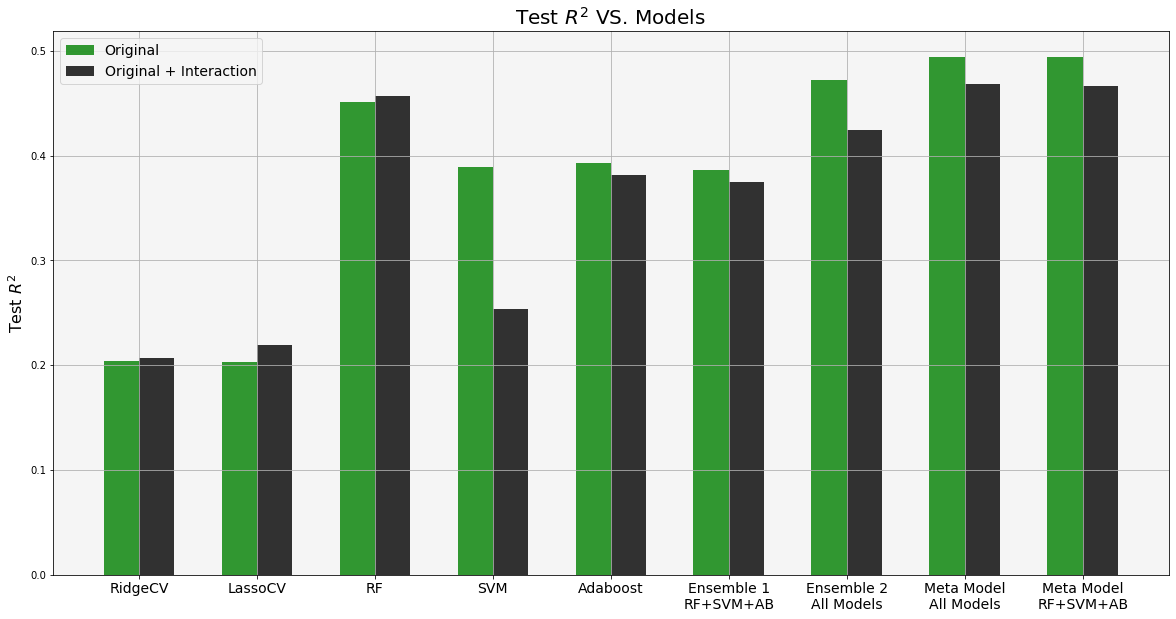

In [95]:
##Plotting the R-Squared results
model_names = ['RidgeCV', 'LassoCV', 'RF', 'SVM', 'Adaboost', 'Ensemble 1\nRF+SVM+AB', 'Ensemble 2\nAll Models',
              'Meta Model\nAll Models', 'Meta Model\nRF+SVM+AB']
r2_test_simple_new = r2_test_simple[1:len(r2_test_simple)]
r2_test_int_new = r2_test_int[1:len(r2_test_int)]
width = 0.3
plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(model_names)), r2_test_simple_new, width, alpha=0.8, label='Original', color = 'green')
plt.bar(np.arange(len(model_names))+width, r2_test_int_new, width, alpha=0.8, label='Original + Interaction', color = 'black')
plt.xticks(np.arange(len(model_names))+0.5*width, model_names, fontsize=14)
plt.title('Test $R^2$ VS. Models ', fontsize=20)
plt.ylabel('Test $R^2$', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('R2.jpg')
plt.show()

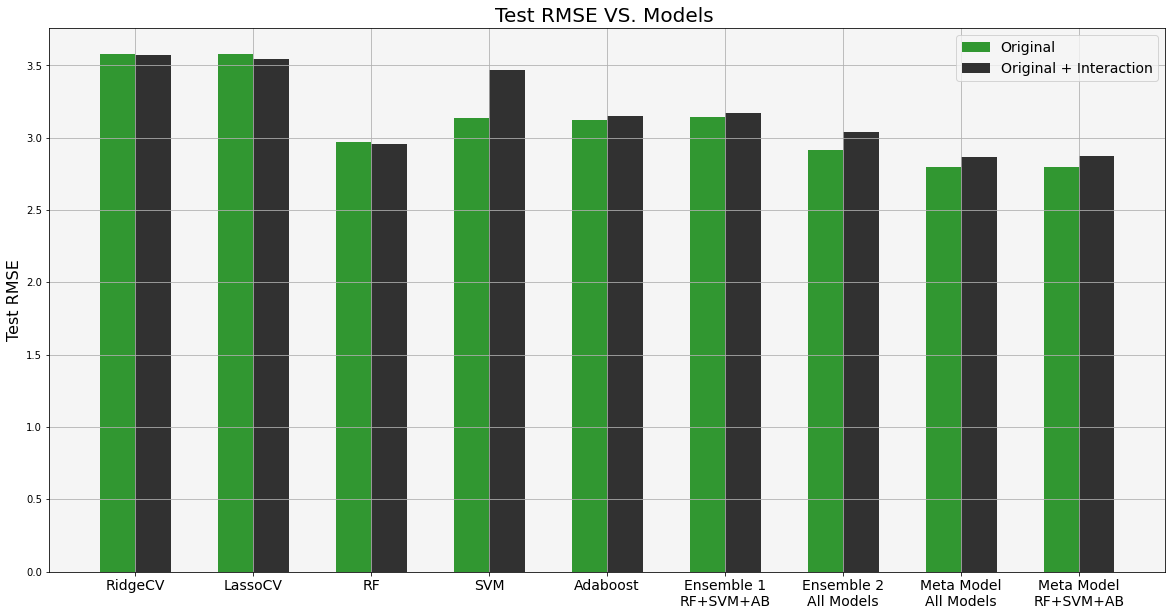

In [97]:
##Plotting the RMSE results
model_names = ['RidgeCV', 'LassoCV', 'RF', 'SVM', 'Adaboost', 'Ensemble 1\nRF+SVM+AB', 'Ensemble 2\nAll Models',
              'Meta Model\nAll Models', 'Meta Model\nRF+SVM+AB']
RMSE_test_simple_new = RMSE_test_simple[1:len(RMSE_test_simple)]
RMSE_test_int_new = RMSE_test_int[1:len(RMSE_test_int)]
width = 0.3
plt.figure(figsize=(20, 10))
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.grid()
plt.bar(np.arange(len(model_names)), RMSE_test_simple_new, width, alpha=0.8, label='Original', color = 'green')
plt.bar(np.arange(len(model_names))+width, RMSE_test_int_new, width, alpha=0.8, label='Original + Interaction', color = 'black')
plt.xticks(np.arange(len(model_names))+0.5*width, model_names, fontsize=14)
plt.title('Test RMSE VS. Models ', fontsize=20)
plt.ylabel('Test RMSE', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('RMSE.jpg')
plt.show()